In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset # Network Common Data Form

%run ImportData.ipynb
%run View_ITCZ_Events.ipynb
%run AlignDatasets.ipynb
%run TimeAvg.ipynb

Please note:
	1:dITCZ, 2:nITCZ, 3:sITCZ, 4:aITCZ, 5:eITCZ
	Event duration has units of days

Days s/ 01-01-2010:  0.0   |  Days s/ 09-01-2009:  122.0  |  ITCZ state:  2  |  Event duration:  2
Days s/ 01-01-2010:  4.0   |  Days s/ 09-01-2009:  126.0  |  ITCZ state:  2  |  Event duration:  3
Days s/ 01-01-2010:  7.0   |  Days s/ 09-01-2009:  129.0  |  ITCZ state:  1  |  Event duration:  2
Days s/ 01-01-2010:  10.0   |  Days s/ 09-01-2009:  132.0  |  ITCZ state:  2  |  Event duration:  2
Days s/ 01-01-2010:  14.0   |  Days s/ 09-01-2009:  136.0  |  ITCZ state:  2  |  Event duration:  2
Days s/ 01-01-2010:  18.0   |  Days s/ 09-01-2009:  140.0  |  ITCZ state:  1  |  Event duration:  4
Days s/ 01-01-2010:  24.0   |  Days s/ 09-01-2009:  146.0  |  ITCZ state:  2  |  Event duration:  4
Days s/ 01-01-2010:  28.0   |  Days s/ 09-01-2009:  150.0  |  ITCZ state:  4  |  Event duration:  4
Days s/ 01-01-2010:  33.0   |  Days s/ 09-01-2009:  155.0  |  ITCZ state:  4  |  Event duration:  4
Days s/ 01

In [2]:
# ************************************************************************************************
# *************************** USER INPUTS ARE REQUIRED IN THIS CELL ******************************
# ************************************************************************************************


#### Select the date to be analyzed as a value representing the number of days since 2009-09-01 ####
dayOfTheSeason = 175 # For reference: 174 is February 22 and 122 is January 1

#### Select which day forecast should be used ####
DayXXHcast = [5,10,15,20]  # Must be a list of integer(s) from >=1 and <=20

# choose region of interest 
lats = -20
latn =  20
lonw = -130 # For  longitudes west of the Prime Meridian, enter a negative number
lone = -90  

# ************************************************************************************************

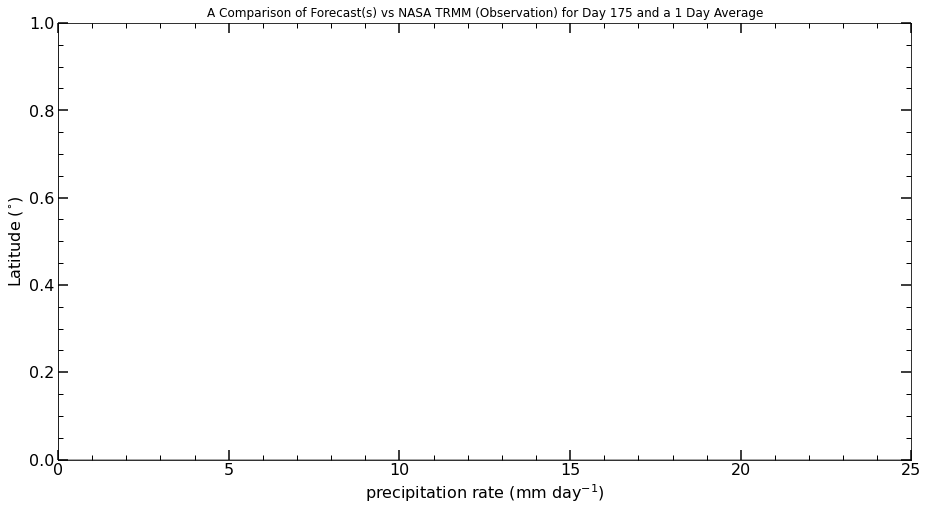

In [3]:
# An initial run must be done so that the code knows the length of all variables when performing the average across events 

#### *** For this script the num of days should remain at 1 *** ####
numDayAvg = 1

userInputs = [dayOfTheSeason,lats,latn,lonw,lone]

# Pack coordinates into list

# Setup plot
fig = plt.figure(figsize=(13, 7.2), tight_layout='true')
plt.minorticks_on()
ax=fig.add_axes()
plt.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axhline(0, color='0.65', linewidth = 2.0, zorder=-1)
plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-2)
plt.ylabel('Latitude $(^{\circ})$', fontsize=16)
plt.xlabel('precipitation rate (mm day$^{-1}$)', fontsize=16)
plt.title("A Comparison of Forecast(s) vs NASA TRMM (Observation) for Day "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average")
plt.xlim([0,25])
plotColors = ['#C8102E','#F1BE48','#524727','#9B945F','#CAC7A7'] # Go Cyclones! :)
plotLegend = []
plotLegend.append('TRMM')

# Loop through the DayXXFcast list to overlay multiple days of forecasts
for ii,DayXX in enumerate(DayXXHcast):
    
    # Use the AlignDatasets function to obtain the aligned datasets
    precip_aligned, precip_aligned_obs, lat_plt, lat_plt_obs, id_DayOfTheSeason = AlignDatasets(timeDayXX[DayXX], lat, lon, precipDayXX[DayXX], rootgrp_obs, userInputs)
    
    # Use the TimeAvg function to time average the precip data over the user specified numDayAvg period
    precip_avg = TimeAvg(precip_aligned,numDayAvg,id_DayOfTheSeason)
    
    # Take an average of all lon values at each lat value (axis=1). Changes matrix size from a (for ex) (127, 40) to a (127,)
    precip_lonavg_mps = np.mean(precip_avg,axis=1) 
    
    # change units from m/s to mm/day
    precip_lonavg = precip_lonavg_mps*1000*86400    
    
    if ii == 0: # Only plot the observation data once as it does not change
        precip_avg_obs = TimeAvg(precip_aligned_obs,numDayAvg,id_DayOfTheSeason)
        precip_lonavg_obs = np.mean(precip_avg_obs,axis=1)
        
        #p0 = plt.plot(precip_lonavg_obs, lat_plt_obs, color='#377eb8', linestyle='dashed', linewidth = 3, label = 'TRMM')

    # Plot the data output by the AlignDatasets function
    #p1 = plt.plot(precip_lonavg, lat_plt, color = plotColors[ii], linewidth = 2.5, label = 'Day '+str(DayXX))  

#plt.legend()
#plt.show()

In [4]:
# Initialize the total precipitation variables. The first dimension refers to a different forcecast day. 
# ...This is the same length as the length of the list of fcast days the user gives

dITCZ.precip_lonavg_tot = np.zeros((len(DayXXHcast),len(precip_lonavg)))
dITCZ.precip_lonavg_obs_tot = np.zeros(precip_lonavg_obs.shape) 
dITCZ.lat_plt_tot = np.zeros((len(DayXXHcast),len(lat_plt)))
dITCZ.lat_plt_obs_tot = np.zeros(lat_plt_obs.shape)

In [5]:
### This cell adds the precipitation for each day in an event, for all events in Dr. Gonzalez's ITCZ events dataset

Ocounter = 0
Mcounter = 0
Icounter = 0

# Outer loop iterates through all the dITCZ events
for ii,dayOfTheSeason in enumerate(dITCZ.startday):
    
    if int(dayOfTheSeason) == 0 : # Ignore the gaps in the data files except ii=0
        continue
    
    # Middle loop iterates for number of days that the given event lasts
    for jj in range(int(dITCZ.ndevent[ii])):
        
        # Pass a list of the user inputs to the AlignDatasets function
        userInputs = [dayOfTheSeason+jj,lats,latn,lonw,lone]
                    
        # Inner loop iterates for the forecast days requested by user
        for kk,DayXX in enumerate(DayXXHcast):

            # Use the AlignDatasets function to obtain the aligned datasets
            precip_aligned, precip_aligned_obs, lat_plt, lat_plt_obs, id_DayOfTheSeason = AlignDatasets(timeDayXX[DayXX], lat, lon, precipDayXX[DayXX], rootgrp_obs, userInputs)
                
            # Use the TimeAvg function to time average the precip data over the user specified numDayAvg period
            precip_avg = TimeAvg(precip_aligned,numDayAvg,id_DayOfTheSeason)

            # Take an average of all lon values at each lat value (axis=1). Changes matrix size from a (for ex) (127, 40) to a (127,)
            precip_lonavg_mps = np.mean(precip_avg,axis=1) 

            # change units from m/s to mm/day
            precip_lonavg = precip_lonavg_mps*1000*86400 
                
            dITCZ.precip_lonavg_tot[kk] = dITCZ.precip_lonavg_tot[kk] + precip_lonavg
            dITCZ.lat_plt_tot[kk]       = dITCZ.lat_plt_tot[kk]       + lat_plt
            Icounter = Icounter + 1
            
        # The obs data should not be summed 
        precip_avg_obs = TimeAvg(precip_aligned_obs,numDayAvg,id_DayOfTheSeason)
        precip_lonavg_obs = np.mean(precip_avg_obs,axis=1)
        
        dITCZ.precip_lonavg_obs_tot = dITCZ.precip_lonavg_obs_tot + precip_lonavg_obs
        dITCZ.lat_plt_obs_tot       = dITCZ.lat_plt_obs_tot       + lat_plt_obs

        Mcounter = Mcounter + 1 
    Ocounter = Ocounter + 1
            
                 

In [6]:
dITCZ.precip_lonavg     = dITCZ.precip_lonavg_tot/Icounter
dITCZ.lat_plt           = dITCZ.lat_plt_tot/Mcounter
dITCZ.precip_lonavg_obs = dITCZ.precip_lonavg_obs_tot/Icounter
dITCZ.lat_plt_obs       = dITCZ.lat_plt_obs_tot/Mcounter


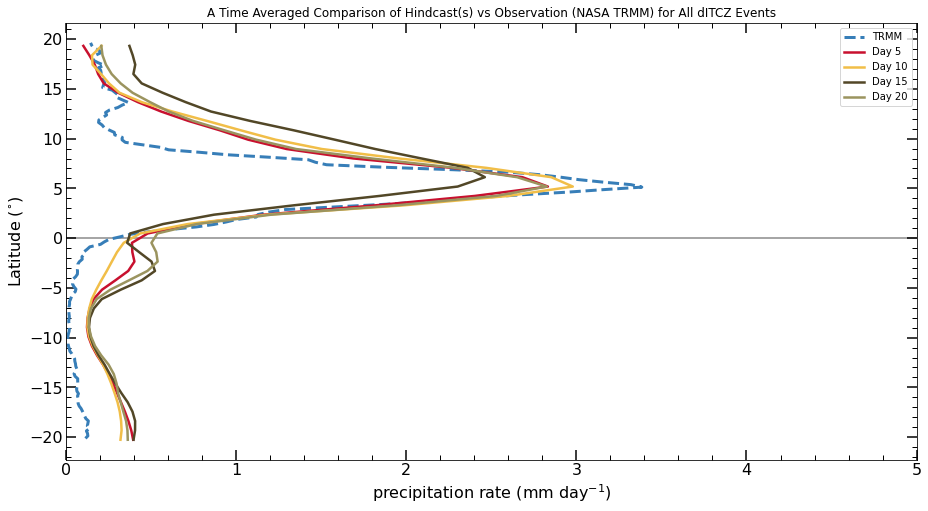

In [7]:
# Align datasets and plot data

# Setup plot
fig = plt.figure(figsize=(13, 7.2), tight_layout='true')
plt.minorticks_on()
ax=fig.add_axes()
plt.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axhline(0, color='0.65', linewidth = 2.0, zorder=-1)
plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-2)
plt.ylabel('Latitude $(^{\circ})$', fontsize=16)
plt.xlabel('precipitation rate (mm day$^{-1}$)', fontsize=16)
plt.title("A Time Averaged Comparison of Hindcast(s) vs Observation (NASA TRMM) for All dITCZ Events")
plt.xlim([0,5])
plotColors = ['#C8102E','#F1BE48','#524727','#9B945F','#CAC7A7'] # Go Cyclones! :)
plotLegend = []
plotLegend.append('TRMM')

# Loop through the DayXXFcast list to overlay multiple days of forecasts
for ii,DayXX in enumerate(DayXXHcast):
    
    if ii == 0: # Only plot the observation once as it does not change
        p0 = plt.plot(dITCZ.precip_lonavg_obs, dITCZ.lat_plt_obs, color='#377eb8', linestyle='dashed', linewidth = 3, label = 'TRMM')

    # Plot the data output by the AlignDatasets function
    p1 = plt.plot(dITCZ.precip_lonavg[ii], dITCZ.lat_plt[ii], color = plotColors[ii], linewidth = 2.5, label = 'Day '+str(DayXX))    

plt.legend()
plt.show()

In [8]:
# Initialize the total precipitation variables. The first dimension refers to a different forcecast day. 
# ...This is the same length as the length of the list of fcast days the user gives

nITCZ.precip_lonavg_tot = np.zeros((len(DayXXHcast),len(precip_lonavg)))
nITCZ.precip_lonavg_obs_tot = np.zeros(precip_lonavg_obs.shape) 
nITCZ.lat_plt_tot = np.zeros((len(DayXXHcast),len(lat_plt)))
nITCZ.lat_plt_obs_tot = np.zeros(lat_plt_obs.shape)

In [9]:
Ocounter = 0
Mcounter = 0
Icounter = 0
Kcounter = 0

# Outer loop iterates through all the dITCZ events
for ii,dayOfTheSeason in enumerate(nITCZ.startday):
    
    if int(dayOfTheSeason) == 0 and ii!=0: # Ignore the gaps in the data files except ii=0
        continue
    
    # Middle loop iterates for number of days that the given event lasts
    for jj in range(int(nITCZ.ndevent[ii])):
        
        # Pass a list of the user inputs to the AlignDatasets function
        userInputs = [dayOfTheSeason+jj,lats,latn,lonw,lone]
                    
        # Inner loop iterates for the forecast days requested by user
        for kk,DayXX in enumerate(DayXXHcast):
    
            # Use the AlignDatasets function to obtain the aligned datasets
            precip_aligned, precip_aligned_obs, lat_plt, lat_plt_obs, id_DayOfTheSeason = AlignDatasets(timeDayXX[DayXX], lat, lon, precipDayXX[DayXX], rootgrp_obs, userInputs)
                
            # Use the TimeAvg function to time average the precip data over the user specified numDayAvg period
            precip_avg = TimeAvg(precip_aligned,numDayAvg,id_DayOfTheSeason)

            # Take an average of all lon values at each lat value (axis=1). Changes matrix size from a (for ex) (127, 40) to a (127,)
            precip_lonavg_mps = np.mean(precip_avg,axis=1) 

            # change units from m/s to mm/day
            precip_lonavg = precip_lonavg_mps*1000*86400 
            
            nITCZ.precip_lonavg_tot[kk] = nITCZ.precip_lonavg_tot[kk] + precip_lonavg
            nITCZ.lat_plt_tot[kk]       = nITCZ.lat_plt_tot[kk]       + lat_plt
            Icounter = Icounter + 1
            
        # The obs data should not be summed
        nITCZ.precip_lonavg_obs_tot = nITCZ.precip_lonavg_obs_tot + precip_lonavg_obs
        nITCZ.lat_plt_obs_tot       = nITCZ.lat_plt_obs_tot       + lat_plt_obs

        Mcounter = Mcounter + 1 
    Ocounter = Ocounter + 1
            
                 

In [10]:
nITCZ.precip_lonavg     = nITCZ.precip_lonavg_tot/Icounter
nITCZ.lat_plt           = nITCZ.lat_plt_tot/Mcounter
nITCZ.precip_lonavg_obs = nITCZ.precip_lonavg_obs_tot/Icounter
nITCZ.lat_plt_obs       = nITCZ.lat_plt_obs_tot/Mcounter


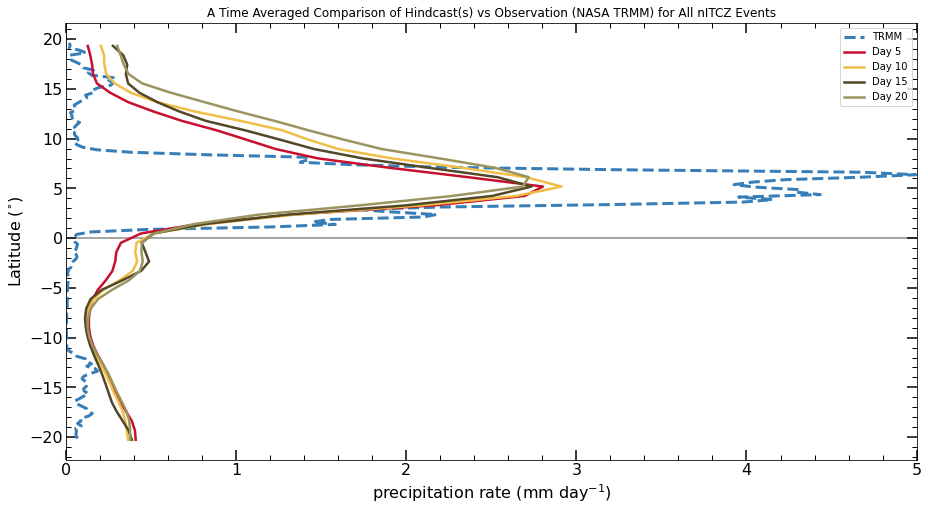

In [11]:
# Align datasets and plot data

# Setup plot
fig = plt.figure(figsize=(13, 7.2), tight_layout='true')
plt.minorticks_on()
ax=fig.add_axes()
plt.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axhline(0, color='0.65', linewidth = 2.0, zorder=-1)
plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-2)
plt.ylabel('Latitude $(^{\circ})$', fontsize=16)
plt.xlabel('precipitation rate (mm day$^{-1}$)', fontsize=16)
plt.title("A Time Averaged Comparison of Hindcast(s) vs Observation (NASA TRMM) for All nITCZ Events")
plt.xlim([0,5])
plotColors = ['#C8102E','#F1BE48','#524727','#9B945F','#CAC7A7'] # Go Cyclones! :)
plotLegend = []
plotLegend.append('TRMM')

# Loop through the DayXXFcast list to overlay multiple days of forecasts
for ii,DayXX in enumerate(DayXXHcast):
    
    if ii == 0: # Only plot the observation once as it does not change
        p0 = plt.plot(nITCZ.precip_lonavg_obs, nITCZ.lat_plt_obs, color='#377eb8', linestyle='dashed', linewidth = 3, label = 'TRMM')

    # Plot the data output by the AlignDatasets function
    p1 = plt.plot(nITCZ.precip_lonavg[ii], nITCZ.lat_plt[ii], color = plotColors[ii], linewidth = 2.5, label = 'Day '+str(DayXX))    

plt.legend()
plt.show()

In [12]:
# Initialize the total precipitation variables. The first dimension refers to a different forcecast day. 
# ...This is the same length as the length of the list of fcast days the user gives

aITCZ.precip_lonavg_tot = np.zeros((len(DayXXHcast),len(precip_lonavg)))
aITCZ.precip_lonavg_obs_tot = np.zeros(precip_lonavg_obs.shape) 
aITCZ.lat_plt_tot = np.zeros((len(DayXXHcast),len(lat_plt)))
aITCZ.lat_plt_obs_tot = np.zeros(lat_plt_obs.shape)

In [13]:
Ocounter = 0
Mcounter = 0
Icounter = 0
Kcounter = 0

# Outer loop iterates through all the dITCZ events
for ii,dayOfTheSeason in enumerate(aITCZ.startday):
    
    if int(dayOfTheSeason) == 0 : # Ignore the gaps in the data files except ii=0
        continue
    
    # Middle loop iterates for number of days that the given event lasts
    for jj in range(int(aITCZ.ndevent[ii])):
        
        # Pass a list of the user inputs to the AlignDatasets function
        userInputs = [dayOfTheSeason+jj,lats,latn,lonw,lone]
                    
        # Inner loop iterates for the forecast days requested by user
        for kk,DayXX in enumerate(DayXXHcast):
    
            # Use the AlignDatasets function to obtain the aligned datasets
            precip_aligned, precip_aligned_obs, lat_plt, lat_plt_obs, id_DayOfTheSeason = AlignDatasets(timeDayXX[DayXX], lat, lon, precipDayXX[DayXX], rootgrp_obs, userInputs)
                
            # Use the TimeAvg function to time average the precip data over the user specified numDayAvg period
            precip_avg = TimeAvg(precip_aligned,numDayAvg,id_DayOfTheSeason)

            # Take an average of all lon values at each lat value (axis=1). Changes matrix size from a (for ex) (127, 40) to a (127,)
            precip_lonavg_mps = np.mean(precip_avg,axis=1) 

            # change units from m/s to mm/day
            precip_lonavg = precip_lonavg_mps*1000*86400 
            
            aITCZ.precip_lonavg_tot[kk] = aITCZ.precip_lonavg_tot[kk] + precip_lonavg
            aITCZ.lat_plt_tot[kk]       = aITCZ.lat_plt_tot[kk]       + lat_plt
            Icounter = Icounter + 1
            
        # The obs data should not be summer 
        aITCZ.precip_lonavg_obs_tot = aITCZ.precip_lonavg_obs_tot + precip_lonavg_obs
        aITCZ.lat_plt_obs_tot       = aITCZ.lat_plt_obs_tot       + lat_plt_obs

        Mcounter = Mcounter + 1 
    Ocounter = Ocounter + 1
            
                 

In [14]:
print(Icounter,Mcounter,Ocounter)

aITCZ.precip_lonavg     = aITCZ.precip_lonavg_tot/Icounter
aITCZ.lat_plt           = aITCZ.lat_plt_tot/Mcounter
aITCZ.precip_lonavg_obs = aITCZ.precip_lonavg_obs_tot/Icounter
aITCZ.lat_plt_obs       = aITCZ.lat_plt_obs_tot/Mcounter


60 15 5


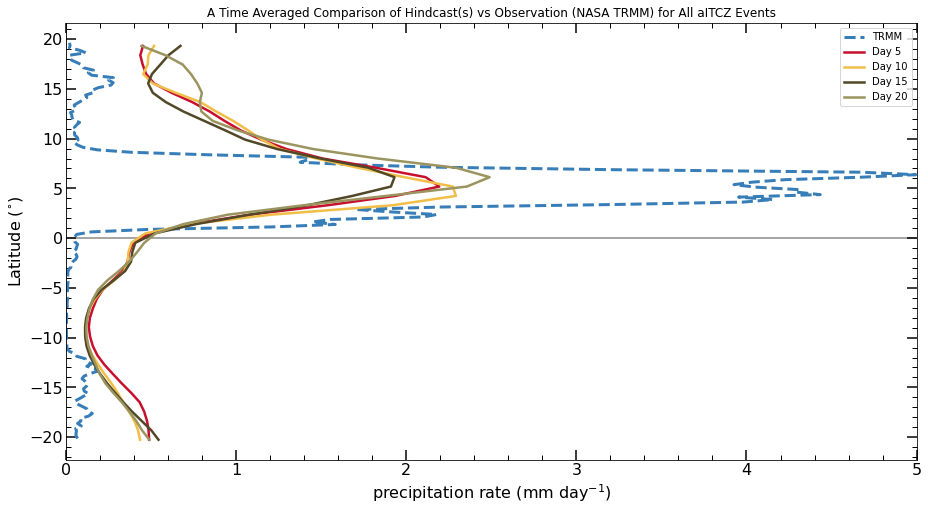

In [15]:
# Align datasets and plot data

# Setup plot
fig = plt.figure(figsize=(13, 7.2), tight_layout='true')
plt.minorticks_on()
ax=fig.add_axes()
plt.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axhline(0, color='0.65', linewidth = 2.0, zorder=-1)
plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-2)
plt.ylabel('Latitude $(^{\circ})$', fontsize=16)
plt.xlabel('precipitation rate (mm day$^{-1}$)', fontsize=16)
plt.title("A Time Averaged Comparison of Hindcast(s) vs Observation (NASA TRMM) for All aITCZ Events")
plt.xlim([0,5])
plotColors = ['#C8102E','#F1BE48','#524727','#9B945F','#CAC7A7'] # Go Cyclones! :)
plotLegend = []
plotLegend.append('TRMM')

# Loop through the DayXXFcast list to overlay multiple days of forecasts
for ii,DayXX in enumerate(DayXXHcast):
    
    if ii == 0: # Only plot the observation once as it does not change
        p0 = plt.plot(aITCZ.precip_lonavg_obs, aITCZ.lat_plt_obs, color='#377eb8', linestyle='dashed', linewidth = 3, label = 'TRMM')

    # Plot the data output by the AlignDatasets function
    p1 = plt.plot(aITCZ.precip_lonavg[ii], aITCZ.lat_plt[ii], color = plotColors[ii], linewidth = 2.5, label = 'Day '+str(DayXX))    

plt.legend()
plt.show()